In [1]:
import scipy
from glob import glob
import os
from PIL import Image
from scipy.misc import imresize
import numpy as np
import matplotlib.pyplot as plt
import scipy
from keras import backend as K
from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.models import model_from_json
import sys
#from livelossplot import PlotLossesKeras
#from data_loader import DataLoader
import numpy as np
import scipy
from glob import glob
import os
import cv2
from PIL import Image
import time
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint,LearningRateScheduler

Using TensorFlow backend.


In [2]:
import math
def step_decay(epoch):
    
    
    initial_lrate=0.1
    drop=0.6
    epochs_drop = 3.0
    lrate= initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate
   

lrate = LearningRateScheduler(step_decay)
callbacks_list = [ lrate]


In [3]:
img_res=(512, 512)
dataset_name = 'PIX'
img_res = img_res
image_size = 512
img_rows = 512
img_cols = 512
channels = 3
img_shape = (img_rows, img_cols, channels)
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)
disc_loss =[]
gen_loss = []
# Number of filters in the first layer of G and D
gf = 64
df = 64
optimizer = Adam(0.0002, 0.5)
#train_A = load_data('/home/iiita/Music/m-cycle/trainAA/*')
#train_B = load_data('/home/iiita/Music/m-cycle/trainBB/*')
#val_A = load_data('/home/iiita/Music/m-cycle/testA/*')
#val_B = load_data('/home/iiita/music/m-cycle/testB/*')
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

In [4]:
def load_data( batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"
        path = glob('./datasets/%s/%s/*' % (dataset_name, data_type))
        batch_size=3
        if batch_size > 0:
            batch_images = np.random.choice(path, size=batch_size)
        else:
            batch_images = np.array([])
        #batch_images = np.random.choice(path, size=batch_size)

        imgs_A = []
        imgs_B = []
        for img_path in batch_images:
            img = imread(img_path)

            h, w, _ = img.shape
            _w = int(w/2)
            img_A, img_B = img[:, :_w, :], img[:, _w:, :]

            img_A = scipy.misc.imresize(img_A, img_res)
            img_B = scipy.misc.imresize(img_B, img_res)

            # If training => do random flip
            if not is_testing and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)

        imgs_A = np.array(imgs_A)/127.5 - 1.
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

In [5]:
def load_batch(batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path = glob('./datasets/%s/%s/*' % (dataset_name, data_type))
        batch_size=3
        n_batches = int(len(path) / batch_size)

        for i in range(n_batches-1):
            batch = path[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img in batch:
                img = imread(img)
                h, w, _ = img.shape
                half_w = int(w/2)
                img_A = img[:, :half_w, :]
                img_B = img[:, half_w:, :]

                img_A = scipy.misc.imresize(img_A, img_res)
                img_B = scipy.misc.imresize(img_B, img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B


In [6]:
def m_batch(batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path = glob('./datasets/%s/%s/*' % (dataset_name, data_type))
        batch_size=3
        m_batches = int(len(path) / batch_size)
        return m_batches

In [7]:
def imread(path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

In [8]:
def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

In [9]:
def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

In [10]:
def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d


In [11]:
def build_generator():
        """U-Net Generator"""

        

        # Image input
        d0 = Input(shape=img_shape)

        # Downsampling
        d1 = conv2d(d0, gf, bn=False)
        d2 = conv2d(d1, gf*2)
        d3 = conv2d(d2, gf*4)
        d4 = conv2d(d3, gf*8)
        d5 = conv2d(d4, gf*8)
        d6 = conv2d(d5, gf*8)
        d7 = conv2d(d6, gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, gf*8)
        u2 = deconv2d(u1, d5, gf*8)
        u3 = deconv2d(u2, d4, gf*8)
        u4 = deconv2d(u3, d3, gf*4)
        u5 = deconv2d(u4, d2, gf*2)
        u6 = deconv2d(u5, d1, gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

In [12]:
 def build_discriminator2():

        img = Input(shape=img_shape)

        model = Sequential()
        model.add(Dense(512, input_shape=img_shape ))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1))

        validity = model(img)

        return Model(img, validity)

In [13]:
 def build_discriminator():

        # Concatenate image and conditioning image by channels to produce input
        #combined_imgs = Concatenate(axis=-1)([img_A, img_B])
        img = Input(shape=img_shape)
        d1 = d_layer(img, df, bn=False)
        d2 = d_layer(d1, df*2)
        d3 = d_layer(d2, df*4)
        d4 = d_layer(d3, df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

In [14]:
def wasserstein_loss( y_true, y_pred):
    return K.mean(y_true * y_pred)

In [15]:
def display_imageG(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ((X*127.5+127.5).clip(0,255).astype('uint8'))
    int_X = int_X.reshape(-1,image_size,image_size, 3)
    int_X = int_X.reshape(rows, -1, image_size, image_size,3).swapaxes(1,2).reshape(rows*image_size,-1, 3)
    pil_X = Image.fromarray(int_X)
    t = str(round(time.time()))
    os.makedirs('./DUALT/gen',  exist_ok=True)
    pil_X.save("./DUALT/"+'gen/'+ t + ".png", 'PNG')
    #display(pil_X)

In [16]:
def display_imageO(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ((X*127.5+127.5).clip(0,255).astype('uint8'))
    int_X = int_X.reshape(-1,image_size,image_size, 3)
    int_X = int_X.reshape(rows, -1, image_size, image_size,3).swapaxes(1,2).reshape(rows*image_size,-1, 3)
    pil_X = Image.fromarray(int_X)
    t = str(round(time.time()))
    os.makedirs('./DUALT/orig',  exist_ok=True)
    pil_X.save("./DUALT/"+'orig/'+ t+".png", 'PNG')
    #display(pil_X)

In [17]:
discriminator = build_discriminator()
discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
#plot_model(discriminator, to_file='./DUALT/Dis.png', show_shapes=True, show_layer_names=True)
        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

# Build the generator
generator = build_generator()
#plot_model(discriminator, to_file='./DUALT/com.png', show_shapes=True, show_layer_names=True)

In [18]:
D_A = build_discriminator()
D_A.compile(loss= wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])
D_B = build_discriminator()
D_B.compile(loss= wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
G_AB = build_generator()
G_BA = build_generator()

# For the combined model we will only train the generators
D_A.trainable = False
D_B.trainable = False

        # The generator takes images from their respective domains as inputs
imgs_A = Input(shape=img_shape)
imgs_B = Input(shape=img_shape)


In [19]:
# Generators translates the images to the opposite domain
fake_B = G_AB(imgs_A)
fake_A = G_BA(imgs_B)

# The discriminators determines validity of translated images
valid_A = D_A(fake_A)
valid_B = D_B(fake_B)

# Generators translate the images back to their original domain
recov_A = G_BA(fake_B)
recov_B = G_AB(fake_A)

# The combined model  (stacked generators and discriminators)
combined = Model(inputs=[imgs_A, imgs_B], outputs=[valid_A, valid_B, recov_A, recov_B])
combined.compile(loss=[wasserstein_loss, wasserstein_loss, 'mae', 'mae'],
                            optimizer=optimizer,
                            loss_weights=[1, 1, 100, 100])
#plot_model(discriminator, to_file='./DUALT/gen.png', show_shapes=True, show_layer_names=True)

In [20]:
def sample_images(epoch, batch_i):
        os.makedirs('images/%s' % dataset_name, exist_ok=True)
        r, c = 3, 3
        batch_size=2
        imgs_A, imgs_B = load_data(batch_size=2, is_testing=True)
        fake_B = G_AB.predict(imgs_A)
        fake_A = G_BA.predict(imgs_B)
        gen_imgs = np.concatenate([imgs_A, fake_B, imgs_B, fake_A])
        gen_imgs = gen_imgs.reshape((r, c, img_rows, img_cols, 3))
        #print(imgs_A.shape)
        display_imageG(fake_A)
        display_imageO(gen_imgs)
        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (dataset_name, epoch, batch_i))
        plt.close()

In [21]:
def save_imgs( epoch, X_A, X_B):
        r, c = 4, 4

        # Sample generator inputs
        imgs_A = sample_generator_input(X_A, c)
        imgs_B = sample_generator_input(X_B, c)

        # Images translated to their opposite domain
        fake_B = G_AB.predict(imgs_A)
        fake_A = G_BA.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_A, fake_B, imgs_B, fake_A])
        gen_imgs = gen_imgs.reshape((r, c, img_rows, img_cols, 1))

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[i, j, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()


In [22]:
def display_imageGA(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ((X*127.5+127.5).clip(0,255).astype('uint8'))
    int_X = int_X.reshape(-1,image_size,image_size, 3)
    int_X = int_X.reshape(rows, -1, image_size, image_size,3).swapaxes(1,2).reshape(rows*image_size,-1, 3)
    pil_X = Image.fromarray(int_X)
    t = str(round(time.time()))
    os.makedirs('./DUALTE/genA',  exist_ok=True)
    pil_X.save("./DUALTE/"+'genA/'+ t + ".png", 'PNG')

In [23]:
def display_imageGB(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ((X*127.5+127.5).clip(0,255).astype('uint8'))
    int_X = int_X.reshape(-1,image_size,image_size, 3)
    int_X = int_X.reshape(rows, -1, image_size, image_size,3).swapaxes(1,2).reshape(rows*image_size,-1, 3)
    pil_X = Image.fromarray(int_X)
    t = str(round(time.time()))
    os.makedirs('./DUALTE/genB',  exist_ok=True)
    pil_X.save("./DUALTE/"+'genB/'+ t + ".png", 'PNG')

In [24]:
def display_imageOA(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ((X*127.5+127.5).clip(0,255).astype('uint8'))
    int_X = int_X.reshape(-1,image_size,image_size, 3)
    int_X = int_X.reshape(rows, -1, image_size, image_size,3).swapaxes(1,2).reshape(rows*image_size,-1, 3)
    pil_X = Image.fromarray(int_X)
    t = str(round(time.time()))
    os.makedirs('./DUALTE/oriA',  exist_ok=True)
    pil_X.save("./DUALTE/"+'oriA/'+ t + ".png", 'PNG')

In [25]:
def display_imageOB(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ((X*127.5+127.5).clip(0,255).astype('uint8'))
    int_X = int_X.reshape(-1,image_size,image_size, 3)
    int_X = int_X.reshape(rows, -1, image_size, image_size,3).swapaxes(1,2).reshape(rows*image_size,-1, 3)
    pil_X = Image.fromarray(int_X)
    t = str(round(time.time()))
    os.makedirs('./DUALTE/oriB',  exist_ok=True)
    pil_X.save("./DUALTE/"+'oriB/'+ t + ".png", 'PNG')

In [26]:
 def sample_images( epoch, batch_i):
        os.makedirs('images/%s' % dataset_name, exist_ok=True)
        r, c = 3, 3
        batch_size=2
        imgs_A, imgs_B = load_data(batch_size=1, is_testing=True)

        # Translate images to the other domain
        fake_B = G_AB.predict(imgs_A)
        fake_A = G_BA.predict(imgs_B)
        # Translate back to original domain
        #reconstr_A = g_BA.predict(fake_B)
        #reconstr_B = g_AB.predict(fake_A)
        display_imageGA(fake_B)
        display_imageOA(imgs_A)
        display_imageGB(fake_A)
        display_imageOB(imgs_B)
        #display_imageRA(reconstr_A)
        #display_imageRB(reconstr_B)
        gen_imgs = np.concatenate([imgs_A, fake_B, imgs_B, fake_A])
        #gen_imgs = gen_imgs.reshape((r, c, img_rows, img_cols, 1))

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[j,i].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images12/%s/%d_%d.png" % (dataset_name, epoch, batch_i))
plt.close()

In [27]:
 def train( epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()
        iteration = 1
        lossGt = []
        lossDt = []
        idata = []
        clip_value = 0.01
        # Adversarial loss ground truths
        #print(imgs_B.shape)
        valid = np.ones((batch_size,) + disc_patch)
        fake = np.zeros((batch_size,) + disc_patch)
        n_batches =  m_batch(batch_size=1, is_testing=False)
        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(batch_size)):
                #print(imgs_B.shape)
                # ---------------------
                #  Train Discriminator
                # ---------------------
                #rgb = cv2.resize(imgs_B, (256, 256)) 
                #print(imgs_B.shape)
                fake_B = G_AB.predict(imgs_A)
                fake_A = G_BA.predict(imgs_B)

                # Train the discriminators
                D_A_loss_real = D_A.train_on_batch(imgs_A, valid)
                D_A_loss_fake = D_A.train_on_batch(fake_A, fake)

                D_B_loss_real = D_B.train_on_batch(imgs_B, valid)
                D_B_loss_fake = D_B.train_on_batch(fake_B, fake)

                D_A_loss = 0.5 * np.add(D_A_loss_real, D_A_loss_fake)
                D_B_loss = 0.5 * np.add(D_B_loss_real, D_B_loss_fake)
                for d in [D_A, D_B]:
                    for l in d.layers:
                        weights = l.get_weights()
                        weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                        l.set_weights(weights)

                g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, valid, imgs_A, imgs_B])
                d_loss = D_A_loss + D_B_loss

                #fake_A = generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                #d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
                #d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
                #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                #disc_loss.append(d_loss)
                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                #g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
                gen_loss.append(g_loss)
                elapsed_time = datetime.datetime.now() - start_time
                
                
                # Plot the progress
                
                
                #generator.save_weights(save_name.format('tf_GE_weights'))
                
                # If at save interval => save generated image samples
                
                if batch_i % sample_interval == 0:
                    sample_images(epoch, batch_i)
                    D_A.save_weights('./DUALTE/weights/d_a_weights222221.h5', True)
                    D_B.save_weights('./DUALTE/weights/d_b_weights222221.h5', True)
                    G_AB.save_weights('./DUALTE/weights/G_ab_weights222221.h5', True)
                    G_BA.save_weights('./DUALTE/weights/G_ba_weights222221.h5', True)
                    combined.save_weights('./DUALTE/weights/combinea_weights222221.h5', True)
                   
                    # generator.save_weights('./DUALT/weights/generator_weights222.h5', True)
                     #discriminator.save_weights('./DUALT/weights/discriminator_weights222.h5', True)
                    print(batch_i)
                    
                     #save_imgs(epoch, X_A, X_B)
                     
                     #plt.close(fig)



/home/cvbl/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/cvbl/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/home/cvbl/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/home/cvbl/anaconda3/envs/keras/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `mode

0
200
0
200
0
200


KeyboardInterrupt: 

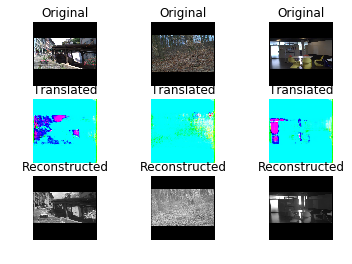

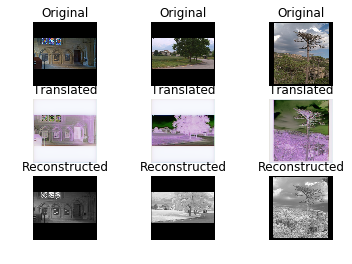

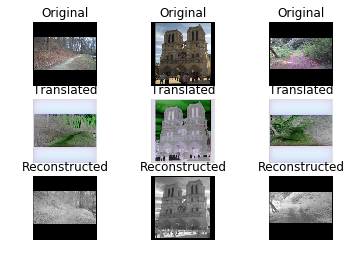

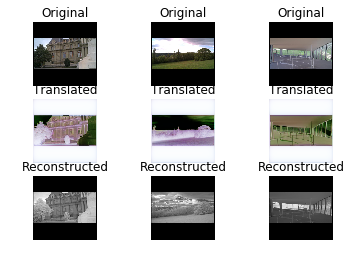

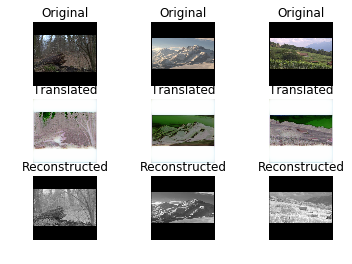

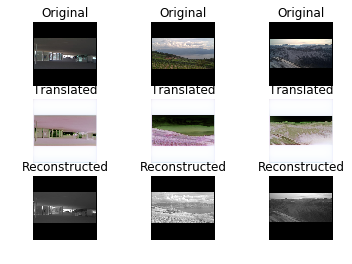

In [28]:
train(epochs=1000, batch_size=3, sample_interval=200)

In [ ]:
'''''print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                       batch_i, n_batches,
                                                                       d_loss[0], 100*d_loss[1],''''
               

In [ ]:
                                                        g_loss[0],elapsed_time))'''''
                ''''lossGt.append(g_loss[0]) 
                lossDt.append(d_loss[0])
                ##print(lossDt)
                #print()
                iteration = (epoch%epochs) + (batch_i/n_batches)
                #print(iteration)
                
                idata.append(iteration)
                #print(idata)
                fig = plt.figure(1)
                # plt.plot(lossGt, label='GLoss')
                plt.plot(idata, lossGt, color='green',
                             label='Generator Loss')
                plt.plot(idata,lossDt ,color='blue',
                             label='Discriminator Loss')
                plt.title("pIXTrain")
                plt.xlabel(" Iteration")
                plt.ylabel("Loss")
                plt.legend()
                plt.pause(.01)
                plt.show()
                
                #ln.remove()  # remove the a rtist
                
                
                plt.draw()''''